In [1]:
from heron.data import DataWrapper

In [2]:
data = DataWrapper("/home/daniel/repositories/heron-training-data/data/v0d0d1.h5")

In [3]:
import numpy as np

In [153]:
def train(model, likelihood, iterations=100):# Find optimal model hyperparameters
    model.train()
    likelihood.train()
    #test_x = torch.tensor(x[1,59000::2], dtype=torch.float32)
    #test_y = torch.tensor(y[59000::2], dtype=torch.float32)
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=.5)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(iterations):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        string = f'Iter {i+1}/{iterations} - Loss: {loss.item():.3f} '
        if hasattr(model.covar_module.base_kernel, "kernels"):
            for kernel in model.covar_module.base_kernel.kernels:
                string += f" {1e7*kernel.lengthscale.item():.3f}E-7 "
        else:
            string += f" {model.covar_module.base_kernel.lengthscale.item():.3f}"
        string += f"noise: {model.likelihood.noise.item():.3f}"
        print(string)
        optimizer.step()

In [79]:
parameters, x, y = data.get_training_data("IMRPhenomPv2EqualMass")

In [80]:
import matplotlib.pyplot as plt
import numpy as np

In [81]:
import torch
import gpytorch

In [99]:
train_x = torch.tensor(100*x[1,60000::5], dtype=torch.float32)
train_y = torch.tensor(1e20*y[60000::5], dtype=torch.float32)

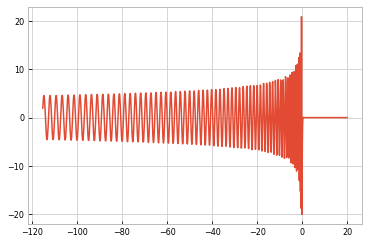

In [100]:
plt.plot(train_x, train_y)

In [112]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(1, 5)) 
    + gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(1, 5))
)

In [181]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.8, 5))
    +gpytorch.kernels.MaternKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.5, 0.8))
    +gpytorch.kernels.MaternKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.3, 0.5))
    +gpytorch.kernels.MaternKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 0.3))
)

In [176]:
#kernel = gpytorch.kernels.ScaleKernel(
#    gpytorch.kernels.MaternKernel() * gpytorch.kernels.PeriodicKernel())

In [177]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0, .5))
model = ExactGPModel(train_x, train_y, likelihood)

In [178]:
train(model, likelihood, 200)

/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 1/200 - Loss: 3.755  28999998.569E-7  6499999.762E-7  4000000.060E-7  2000000.179E-7  500000.007E-7 noise: 0.250
Iter 2/200 - Loss: 3.169  23856809.139E-7  6132622.361E-7  3755081.594E-7  1755081.415E-7  377540.737E-7 noise: 0.311
Iter 3/200 - Loss: 2.868  19302644.730E-7  5813292.265E-7  3544621.766E-7  1558608.711E-7  309537.742E-7 noise: 0.360
Iter 4/200 - Loss: 2.704  16364576.817E-7  5567299.724E-7  3385035.098E-7  1426030.993E-7  267203.934E-7 noise: 0.395
Iter 5/200 - Loss: 2.622  13925559.521E-7  5393161.774E-7  3273033.202E-7  1344860.792E-7  238279.104E-7 noise: 0.419
Iter 6/200 - Loss: 2.575  12038623.095E-7  5275453.329E-7  3197061.121E-7  1297435.015E-7  216863.863E-7 noise: 0.436
Iter 7/200 - Loss: 2.562  10655498.505E-7  5197021.961E-7  3145752.251E-7  1271922.290E-7  200112.667E-7 noise: 0.448
Iter 8/200 - Loss: 2.533  9699723.721E-7  5144503.117E-7  3110678.792E-7  1260887.533E-7  186509.732E-7 noise: 0.457
Iter 9/200 - Loss: 2.527  9073852.301E-7  5108744.502E-7 

Iter 72/200 - Loss: 2.504  8002818.227E-7  5005413.890E-7  3007460.535E-7  2972745.597E-7  95283.147E-7 noise: 0.491
Iter 73/200 - Loss: 2.497  8002808.094E-7  5005394.816E-7  3007436.693E-7  2972636.521E-7  95269.848E-7 noise: 0.491
Iter 74/200 - Loss: 2.504  8002798.557E-7  5005375.743E-7  3007412.553E-7  2972513.139E-7  95257.806E-7 noise: 0.491
Iter 75/200 - Loss: 2.508  8002789.021E-7  5005356.669E-7  3007388.115E-7  2972375.751E-7  95246.900E-7 noise: 0.491
Iter 76/200 - Loss: 2.511  8002779.484E-7  5005337.596E-7  3007363.379E-7  2972223.163E-7  95236.991E-7 noise: 0.490
Iter 77/200 - Loss: 2.508  8002770.543E-7  5005319.118E-7  3007338.345E-7  2972057.760E-7  95228.041E-7 noise: 0.490
Iter 78/200 - Loss: 2.505  8002762.198E-7  5005300.641E-7  3007312.715E-7  2971877.754E-7  95219.919E-7 noise: 0.490
Iter 79/200 - Loss: 2.510  8002753.258E-7  5005282.164E-7  3007287.085E-7  2971684.635E-7  95212.562E-7 noise: 0.490
Iter 80/200 - Loss: 2.508  8002744.913E-7  5005263.686E-7  30072

Iter 143/200 - Loss: 2.510  8002318.740E-7  5004215.240E-7  3005708.456E-7  2926567.793E-7  95142.787E-7 noise: 0.486
Iter 144/200 - Loss: 2.518  8002312.183E-7  5004200.339E-7  3005686.700E-7  2924641.073E-7  95142.787E-7 noise: 0.486
Iter 145/200 - Loss: 2.497  8002306.223E-7  5004185.438E-7  3005665.243E-7  2922621.667E-7  95142.787E-7 noise: 0.485
Iter 146/200 - Loss: 2.501  8002299.666E-7  5004170.537E-7  3005643.785E-7  2920511.365E-7  95142.787E-7 noise: 0.485
Iter 147/200 - Loss: 2.507  8002293.706E-7  5004155.636E-7  3005622.923E-7  2918324.471E-7  95142.787E-7 noise: 0.485
Iter 148/200 - Loss: 2.507  8002287.149E-7  5004140.735E-7  3005601.764E-7  2916022.539E-7  95142.787E-7 noise: 0.485
Iter 149/200 - Loss: 2.514  8002281.189E-7  5004125.834E-7  3005580.902E-7  2913590.074E-7  95142.787E-7 noise: 0.485
Iter 150/200 - Loss: 2.492  8002274.632E-7  5004111.528E-7  3005559.742E-7  2910976.112E-7  95142.787E-7 noise: 0.485
Iter 151/200 - Loss: 2.498  8002268.672E-7  5004096.627E

In [179]:
model.eval()
likelihood.eval()

test_x = torch.tensor(100*x[1,63000::], dtype=torch.float32)

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
#f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

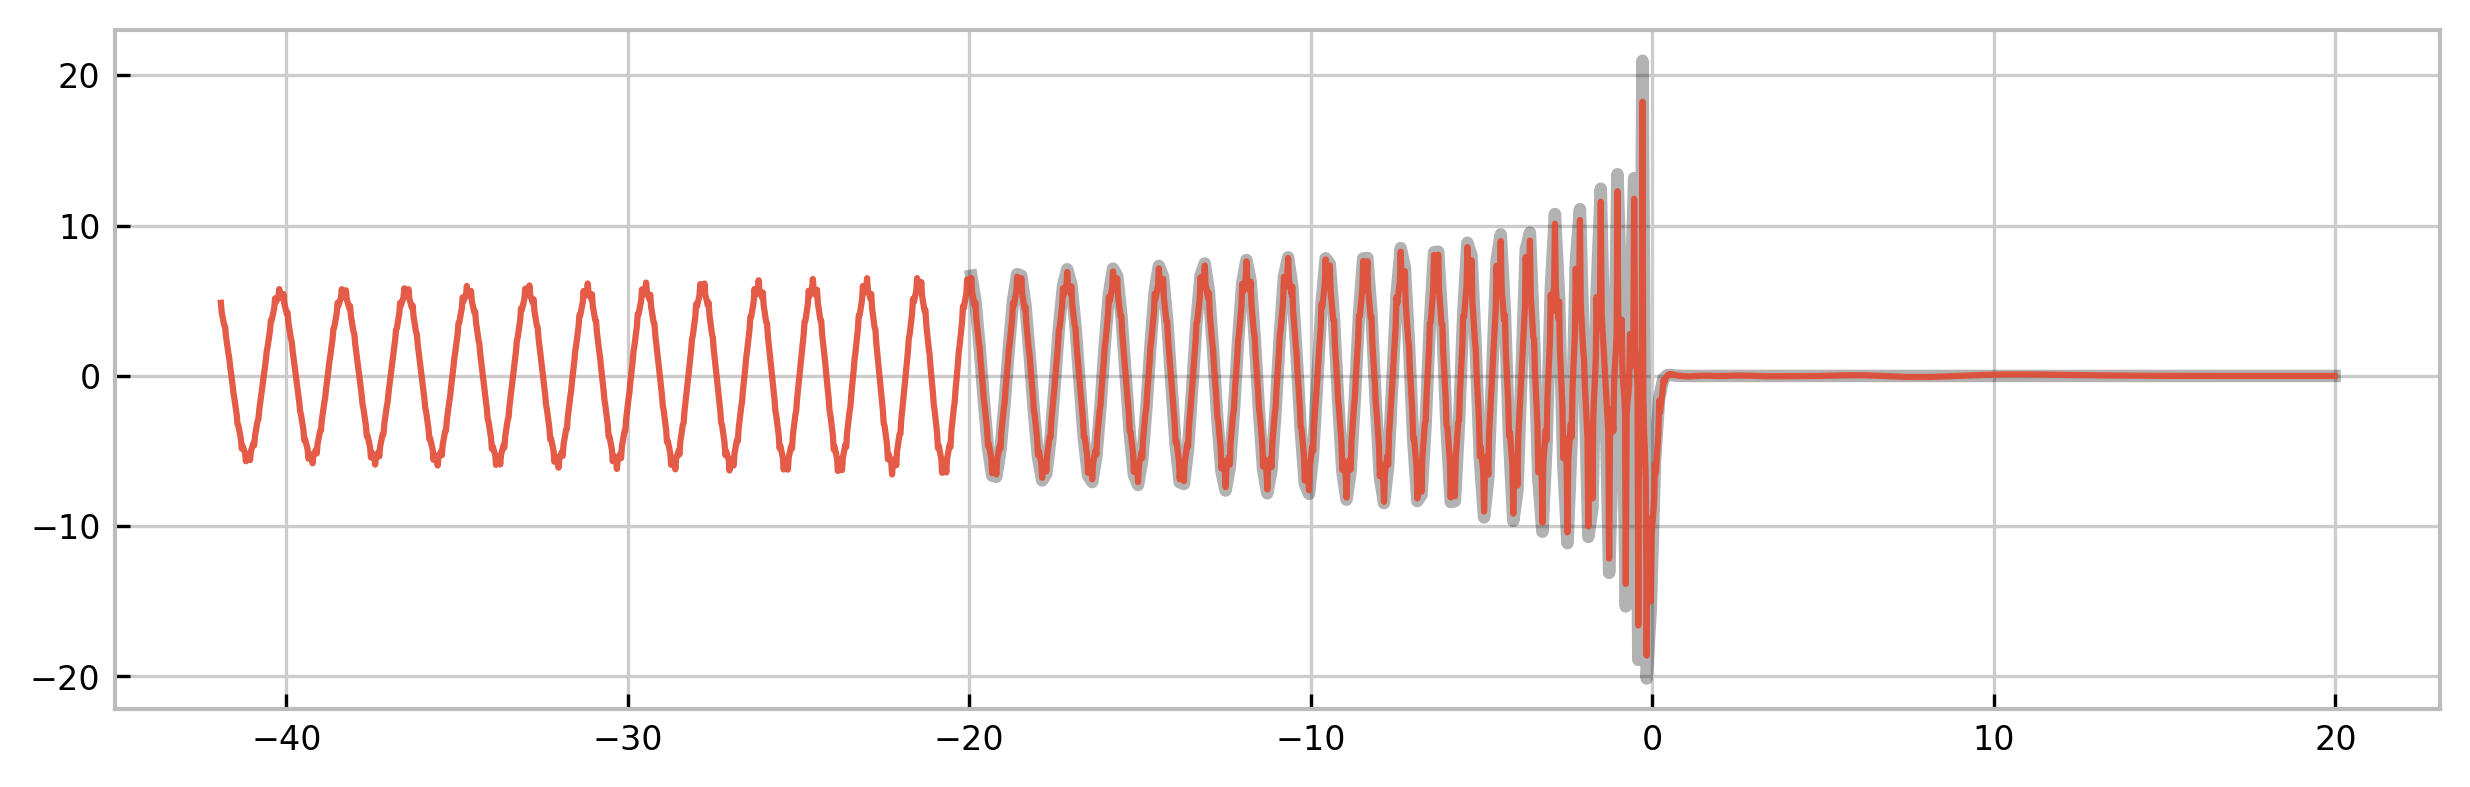

In [180]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,3))
ax.plot(train_x[train_x>-20], train_y.detach().numpy()[train_x>-20], 'k', lw=3, alpha=0.3)
ax.plot(test_x, f_mean.detach().numpy(), alpha=0.9)